# Library

In [60]:
import os
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Flatten, MaxPooling2D, Conv2D, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import scipy
from PIL import Image
import warnings
warnings.catch_warnings
import cv2 as cv
from scipy import stats
from tqdm import tqdm
import shutil
import time

# Load Dataset (Melanoma)

In [2]:
# # Importing required libraries
# import kagglehub

# # Downloading the dataset
# path = kagglehub.dataset_download("drscarlat/melanoma")
# print("Path to dataset files:", path)

# # Moving dataset to the current directory
# destination_dir = '.'  # Current directory

# for item in os.listdir(path):
#     source_path = os.path.join(path, item)
#     destination_path = os.path.join(destination_dir, item)

#     if os.path.isfile(source_path):
#         shutil.move(source_path, destination_path)
#     elif os.path.isdir(source_path):
#         shutil.move(source_path, destination_path)

# print("Dataset files moved to the current directory.")

# Dataset

In [3]:
# Basic config
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
train_path = './dermmel/DermMel/train_sep'
val_path = './dermmel/DermMel/valid'
test_path = './dermmel/DermMel/test'

In [5]:
# Melihat jumlah total dataset dan pembagian kelasnya
def count_dataset(path):
  class_counts = {}
  total_count = 0
  for root, dirs, files in os.walk(path):
    for file in files:
      class_name = os.path.basename(root)
      if class_name not in class_counts:
        class_counts[class_name] = 0
      class_counts[class_name] += 1
      total_count += 1
  return total_count, class_counts


train_total, train_class_counts = count_dataset(train_path)
val_total, val_class_counts = count_dataset(val_path)
test_total, test_class_counts = count_dataset(test_path)

print("Train Dataset:")
print("Total images:", train_total)
print("Class counts:", train_class_counts)

print("\nValidation Dataset:")
print("Total images:", val_total)
print("Class counts:", val_class_counts)

print("\nTest Dataset:")
print("Total images:", test_total)
print("Class counts:", test_class_counts)

Train Dataset:
Total images: 10682
Class counts: {'NotMelanoma': 5341, 'Melanoma': 5341}

Validation Dataset:
Total images: 3562
Class counts: {'NotMelanoma': 1781, 'Melanoma': 1781}

Test Dataset:
Total images: 3561
Class counts: {'NotMelanoma': 1780, 'Melanoma': 1781}


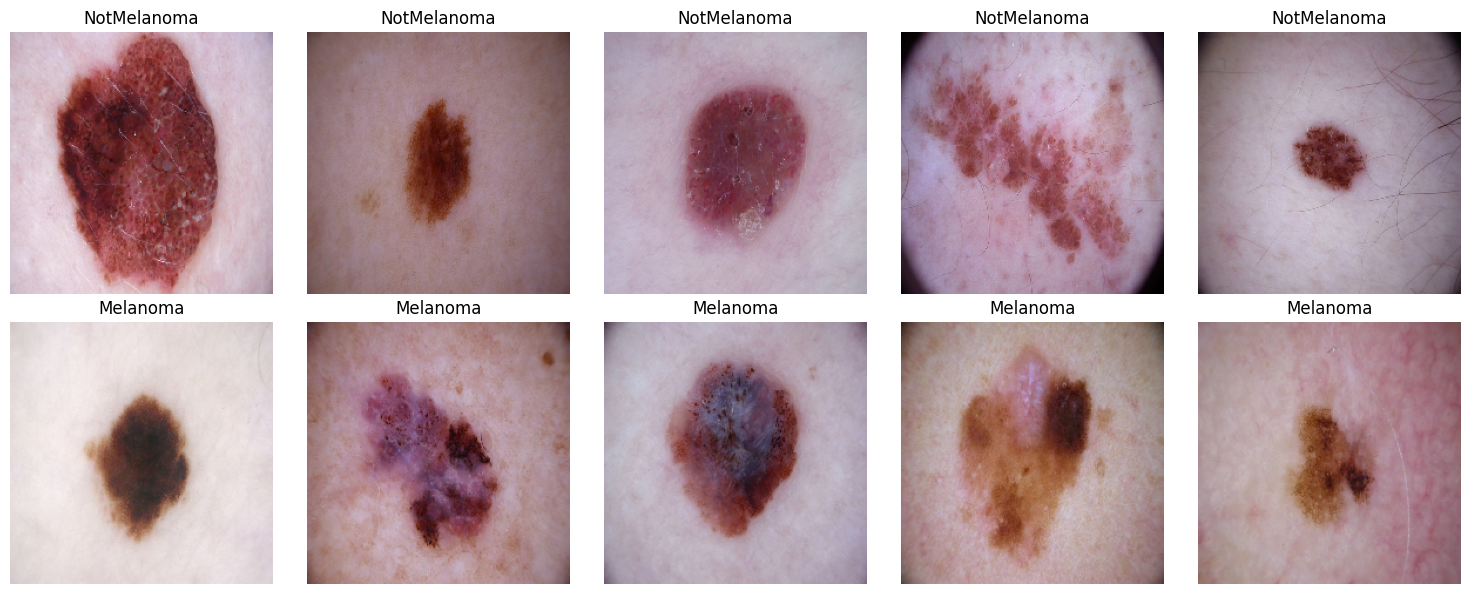

In [6]:
# Melihat sample data
def display_image(dir, num_img=5):
    categories = os.listdir(dir)
    categories = [category for category in categories if category != '.DS_Store']
    fig, ax = plt.subplots(len(categories), num_img, figsize=(num_img*3, len(categories)*3))

    for i, category in enumerate(categories):
        category_dir = os.path.join(dir, category)
        images = os.listdir(category_dir)[:num_img]

        for j, image in enumerate(images):
            img_path = os.path.join(category_dir, image)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

            ax[i,j].imshow(img)
            ax[i,j].set_title(category)
            ax[i,j].axis('off')

    plt.tight_layout()
    plt.show()

display_image(train_path)

In [7]:
classes = [class_name for class_name in os.listdir(train_path)]
classes

['NotMelanoma', 'Melanoma']

# Default (No Hair Removal)

In [8]:
# ImageDataGenerators
# Augmentation
train_datagen_aug = ImageDataGenerator(
    rotation_range = 35,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.3,
    fill_mode = 'nearest',
    )

# No augmentation
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Generators
train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb'
)

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle = False
)

Found 10682 images belonging to 2 classes.
Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [9]:
class CustomF1Score(F1Score):
    def __init__(self, name="f1_score", dtype=None):
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.true_positives = self.add_weight(name="true_positives", initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary based on a 0.5 threshold
        y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        # Calculate true positives, false positives, and false negatives
        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum(y_pred * (1 - y_true))
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        # Update the state variables
        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [10]:
def evaluate_model(model, test_generator, classes, threshold=0.5):
    # Predict labels for the test data
    y_pred = model.predict(test_generator)
    # Binarize predictions based on threshold
    y_pred = (y_pred > threshold).astype(int)
    # Get true labels from the test generator
    y_true = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [11]:
def plot_training_history(history):
    """
    Menampilkan plot akurasi dan loss untuk training dan validation selama epoch dengan rentang y-axis dari 0 hingga 1
    dengan interval 0.1.
    
    Parameter:
    - history: Objek history yang dikembalikan oleh metode fit model.
    """
    plt.figure(figsize=(12, 4))

    # Definisikan ticks dari 0 hingga 1 dengan interval 0.1
    y_ticks = np.arange(0, 1.1, 0.1)

    # Plot akurasi training dan validation
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Training')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)            # Mengatur rentang y-axis dari 0 hingga 1
    plt.yticks(y_ticks)       # Mengatur ticks y-axis dengan interval 0.1
    plt.legend()

    # Plot loss training dan validation
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Training')
    plt.plot(history.history['val_loss'], label='Loss Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 1)            # Mengatur rentang y-axis dari 0 hingga 1
    plt.yticks(y_ticks)       # Mengatur ticks y-axis dengan interval 0.1
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
import pandas as pd

def save_training_history(history, filename):
    """Saves training history to a CSV file with the model name.

    Args:
        history: The training history object returned by model.fit().
        filename: The name of the CSV file to save the history to.
        model_name: The name of the model (string) to include in the CSV file.
    """
    results_df = pd.DataFrame(history.history)
    results_df.insert(0, 'epoch', range(1, len(results_df) + 1))  # Menambahkan kolom 'epoch'
    results_df.to_csv(filename, index=False)

## Standart

In [13]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

2024-12-16 17:01:00.750502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9


In [14]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4)

In [15]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_default_std = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [16]:
model_default_std.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_default_std.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              984064    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [17]:
mcp = ModelCheckpoint('model_default_std.h5', save_best_only = True)

In [18]:
start_time = time.time()

history = model_default_std.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10  # Jika epochs = 30

print(f"Total Training Time: {total_training_time:.2f} detik")
print(f"Average Time: {average_time_per_epoch:.2f} detik")

Epoch 1/10


2024-12-16 17:01:08.365755: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-16 17:01:08.370249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-16 17:01:08.440552: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-16 17:01:09.527503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c03bcc6ad70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-16 17:01:09.527537: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-16 17:01:09.531556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-16 17:01:09.587026: I ./tensorflow/compiler/jit/device_comp

333/333 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.9213 - precision: 0.8941 - recall: 0.9556 - f1_score: 0.9239

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 140s 377ms/step - loss: 1.7350 - accuracy: 0.9213 - precision: 0.8941 - recall: 0.9556 - f1_score: 0.9239 - val_loss: 2.2803 - val_accuracy: 0.5608 - val_precision: 0.5320 - val_recall: 1.0000 - val_f1_score: 0.6945 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 123s 369ms/step - loss: 1.3772 - accuracy: 0.9559 - precision: 0.9354 - recall: 0.9793 - f1_score: 0.9569 - val_loss: 2.2213 - val_accuracy: 0.6287 - val_precision: 0.5736 - val_recall: 1.0000 - val_f1_score: 0.7290 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 114s 343ms/step - loss: 1.0896 - accuracy: 0.9744 - precision: 0.9654 - recall: 0.9840 - f1_score: 0.9746 - val_loss: 2.0100 - val_accuracy: 0.7393 - val_precision: 0.6573 - val_recall: 1.0000 - val_f1_score: 0.7932 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 104s 314ms/step - loss: 0.8520 - accuracy: 0.9902 - precision: 0.9873 - recall: 0.9932 - f1_scor

In [19]:
test_result_no_dhr_std = model_default_std.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_no_dhr_std

112/112 [==============================] - 29s 262ms/step - loss: 0.4926 - accuracy: 0.9542 - precision: 0.9312 - recall: 0.9809 - f1_score: 0.9554


{'loss': 0.4926093518733978,
 'accuracy': 0.9542263150215149,
 'precision': 0.9312000274658203,
 'recall': 0.9808988571166992,
 'f1_score': 0.9554035067558289}

112/112 [==============================] - 14s 125ms/step
Confusion Matrix:
[[1652  129]
 [  34 1746]]


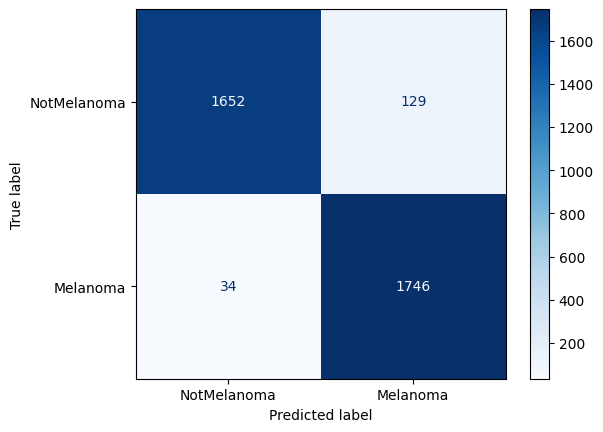

Classification Report:
              precision    recall  f1-score   support

 NotMelanoma     0.9798    0.9276    0.9530      1781
    Melanoma     0.9312    0.9809    0.9554      1780

    accuracy                         0.9542      3561
   macro avg     0.9555    0.9542    0.9542      3561
weighted avg     0.9555    0.9542    0.9542      3561



In [20]:
evaluate_model(model_default_std, test_generator, classes)

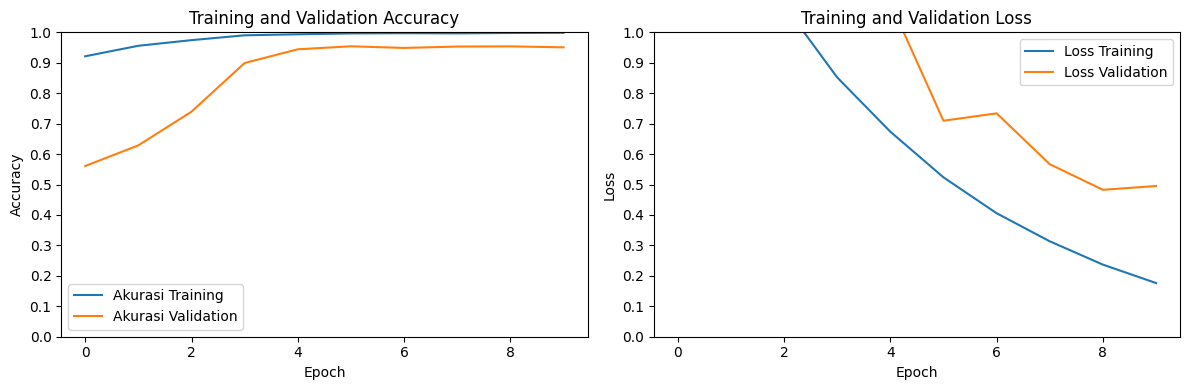

In [21]:
plot_training_history(history)

In [22]:
save_training_history(history, 'model_default_std_train_val_results.csv')

## Augmentation

In [23]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [24]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4)

In [25]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_default_aug = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [26]:
model_default_aug.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_default_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [27]:
mcp = ModelCheckpoint('model_default_aug.h5', save_best_only = True)

In [28]:
start_time = time.time()

history = model_default_aug.fit(
    train_generator_aug,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator_aug.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10  # Jika epochs = 30

print(f"Total Training Time: {total_training_time:.2f} detik")
print(f"Average Time: {average_time_per_epoch:.2f} detik")

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 1.7579 - accuracy: 0.9141 - precision: 0.8890 - recall: 0.9463 - f1_score: 0.9167

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 148s 418ms/step - loss: 1.7579 - accuracy: 0.9141 - precision: 0.8890 - recall: 0.9463 - f1_score: 0.9167 - val_loss: 1.8588 - val_accuracy: 0.8117 - val_precision: 0.7263 - val_recall: 1.0000 - val_f1_score: 0.8414 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 143s 429ms/step - loss: 1.4213 - accuracy: 0.9482 - precision: 0.9209 - recall: 0.9807 - f1_score: 0.9498 - val_loss: 1.5697 - val_accuracy: 0.8739 - val_precision: 0.7988 - val_recall: 1.0000 - val_f1_score: 0.8882 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 137s 413ms/step - loss: 1.1654 - accuracy: 0.9536 - precision: 0.9331 - recall: 0.9773 - f1_score: 0.9547 - val_loss: 1.1394 - val_accuracy: 0.9440 - val_precision: 0.9001 - val_recall: 0.9989 - val_f1_score: 0.9469 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 142s 428ms/step - loss: 0.9450 - accuracy: 0.9602 - precision: 0.9445 - recall: 0.9778 - f1_scor

In [29]:
test_result_no_dhr_aug = model_default_aug.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_no_dhr_aug

112/112 [==============================] - 27s 243ms/step - loss: 0.3089 - accuracy: 0.9489 - precision: 0.9645 - recall: 0.9320 - f1_score: 0.9480


{'loss': 0.30888399481773376,
 'accuracy': 0.948890745639801,
 'precision': 0.9645348787307739,
 'recall': 0.9320224523544312,
 'f1_score': 0.9479999542236328}

112/112 [==============================] - 14s 121ms/step
Confusion Matrix:
[[1720   61]
 [ 121 1659]]


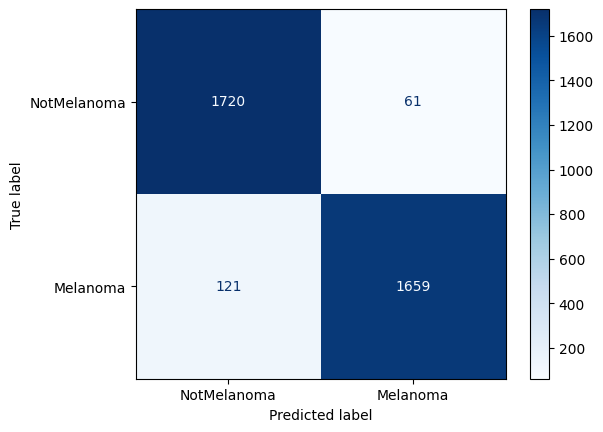

Classification Report:
              precision    recall  f1-score   support

 NotMelanoma     0.9343    0.9657    0.9498      1781
    Melanoma     0.9645    0.9320    0.9480      1780

    accuracy                         0.9489      3561
   macro avg     0.9494    0.9489    0.9489      3561
weighted avg     0.9494    0.9489    0.9489      3561



In [30]:
evaluate_model(model_default_aug, test_generator, classes)

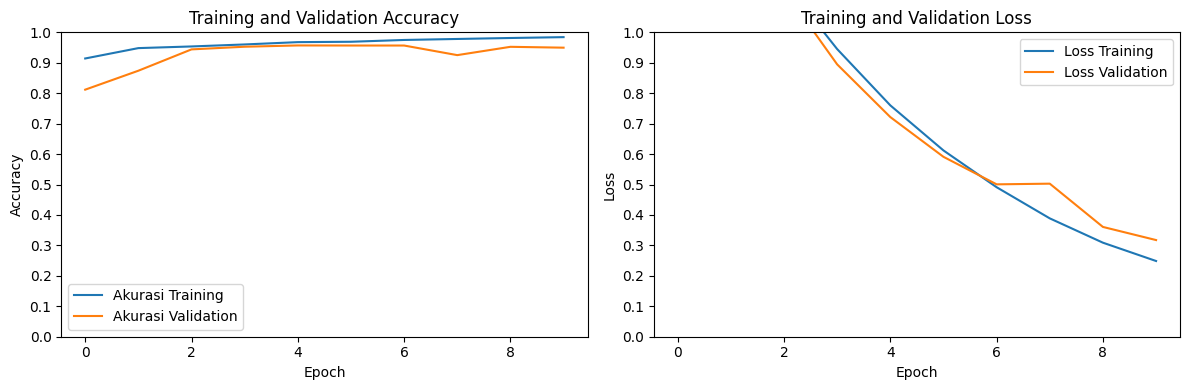

In [31]:
plot_training_history(history)

In [32]:
save_training_history(history, 'model_default_aug_train_val_results.csv')

# Hair Removal (DHR)



In [33]:
import cv2
import numpy as np

def dull_razor_hair_removal(img):
    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply blackhat filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)

    # Threshold to create a binary mask (0=skin, 255=hair)
    lowbound = 12
    _, mask = cv2.threshold(blackhat, lowbound, 255, cv2.THRESH_BINARY)

    # Inpaint to remove hair
    inpaint_radius = 3
    img_final = cv2.inpaint(img, mask, inpaint_radius, cv2.INPAINT_TELEA)

    return img_final

In [34]:
import os
import cv2

def process_and_save_images(input_directory, output_directory, classes):
    """
    Processes images in the input directory using dullrazor_hair_removal function and saves
    the results in the output directory with subdirectories for each class.

    Parameters:
    - input_directory (str): Path to the directory containing input images organized by class.
    - output_directory (str): Path to the directory where processed images will be saved.
    - classes (list): List of class names (e.g., ['Melanoma', 'NotMelanoma']).

    Returns:
    - None
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for class_name in classes:
        class_input_dir = os.path.join(input_directory, class_name)
        class_output_dir = os.path.join(output_directory, class_name)

        if not os.path.exists(class_output_dir):
            os.makedirs(class_output_dir)

        # Process each image in the class directory
        for img_name in os.listdir(class_input_dir):
            input_path = os.path.join(class_input_dir, img_name)
            output_path = os.path.join(class_output_dir, img_name)

            # Read the image
            img = cv2.imread(input_path)
            if img is None:
                print(f"Could not read image {input_path}. Skipping...")
                continue

            # Apply dullrazor_hair_removal
            processed_img = dull_razor_hair_removal(img)

            # Save the processed image
            cv2.imwrite(output_path, processed_img)

    print("Image processing and saving completed.")

# Example usage:
output_directory = "Removed hair images 2"

process_and_save_images(train_path, output_directory, classes)

Image processing and saving completed.


In [35]:
dhr_train_path = './Removed hair images 2'

In [36]:
dhr_train_total, dhr_train_class_counts = count_dataset(dhr_train_path)

print("Removed Hair Dataset:")
print("Total images:", dhr_train_total)
print("Class counts:", dhr_train_class_counts)

Removed Hair Dataset:
Total images: 10682
Class counts: {'NotMelanoma': 5341, 'Melanoma': 5341}


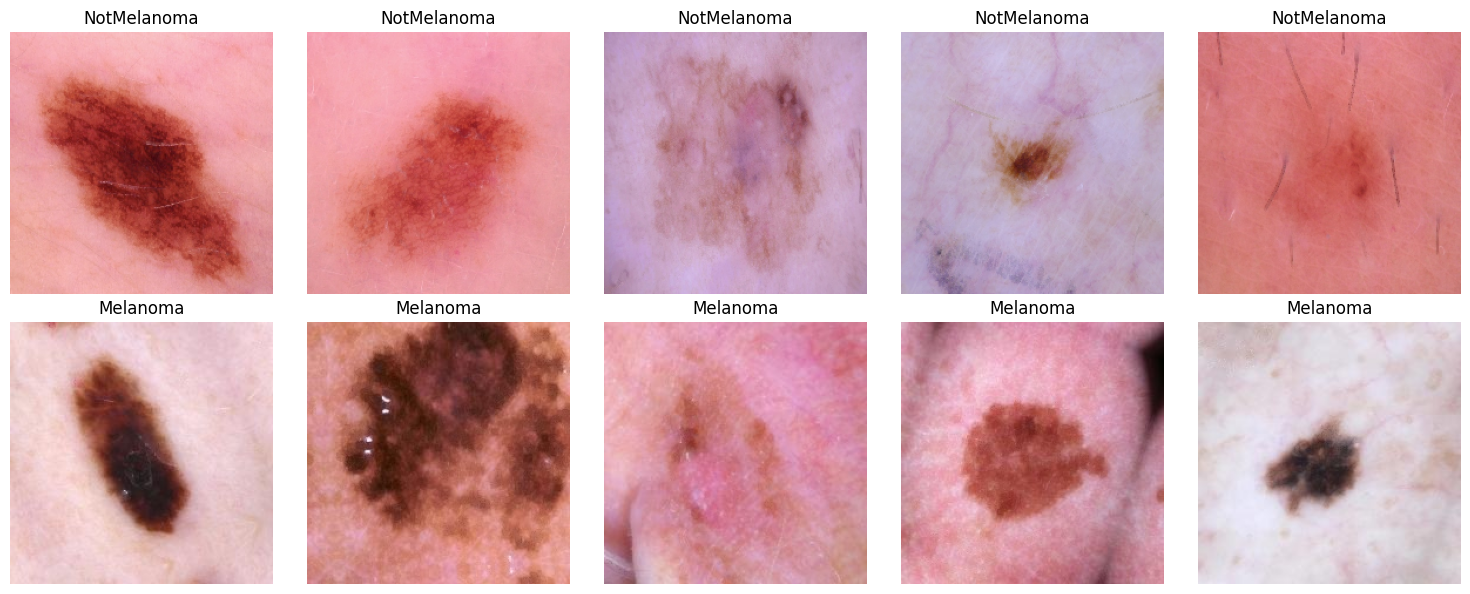

In [37]:
display_image(dhr_train_path)

In [38]:
train_datagen_hair_removal_aug = ImageDataGenerator(
    rotation_range = 35,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.3,
    fill_mode = 'nearest',
    )

train_datagen_hair_removal_std = ImageDataGenerator()

# Generators
train_generator_dhr_aug = train_datagen_hair_removal_aug.flow_from_directory(
    dhr_train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

train_generator_dhr_std = train_datagen_hair_removal_std.flow_from_directory(
    dhr_train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

Found 10682 images belonging to 2 classes.
Found 10682 images belonging to 2 classes.


## Standart



In [39]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [40]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4)

In [41]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_dhr_std = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [42]:
model_dhr_std.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_dhr_std.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

In [43]:
mcp = ModelCheckpoint('model_dhr_std.h5', save_best_only = True)

In [44]:
start_time = time.time()

history = model_dhr_std.fit(
    train_generator_dhr_std,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10  # Jika epochs = 30

print(f"Total Training Time: {total_training_time:.2f} detik")
print(f"Average Time: {average_time_per_epoch:.2f} detik")

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 1.7319 - accuracy: 0.9209 - precision: 0.8955 - recall: 0.9530 - f1_score: 0.9234

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 107s 294ms/step - loss: 1.7319 - accuracy: 0.9209 - precision: 0.8955 - recall: 0.9530 - f1_score: 0.9234 - val_loss: 2.2413 - val_accuracy: 0.5808 - val_precision: 0.5437 - val_recall: 1.0000 - val_f1_score: 0.7044 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 46s 138ms/step - loss: 1.3707 - accuracy: 0.9539 - precision: 0.9315 - recall: 0.9799 - f1_score: 0.9551 - val_loss: 1.6633 - val_accuracy: 0.7396 - val_precision: 0.6579 - val_recall: 0.9983 - val_f1_score: 0.7931 - lr: 1.0000e-04
Epoch 3/10
333/333 [==============================] - 45s 134ms/step - loss: 1.0819 - accuracy: 0.9739 - precision: 0.9642 - recall: 0.9844 - f1_score: 0.9742 - val_loss: 1.8400 - val_accuracy: 0.7092 - val_precision: 0.6324 - val_recall: 1.0000 - val_f1_score: 0.7748 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 47s 143ms/step - loss: 0.8456 - accuracy: 0.9890 - precision: 0.9858 - recall: 0.9923 - f1_score: 

In [45]:
test_result_dhr_std = model_dhr_std.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_dhr_std

112/112 [==============================] - 31s 276ms/step - loss: 0.4214 - accuracy: 0.9461 - precision: 0.9315 - recall: 0.9629 - f1_score: 0.9470


{'loss': 0.4214150607585907,
 'accuracy': 0.9460825324058533,
 'precision': 0.9315217137336731,
 'recall': 0.9629213213920593,
 'f1_score': 0.9469612836837769}

112/112 [==============================] - 15s 132ms/step
Confusion Matrix:
[[1655  126]
 [  66 1714]]


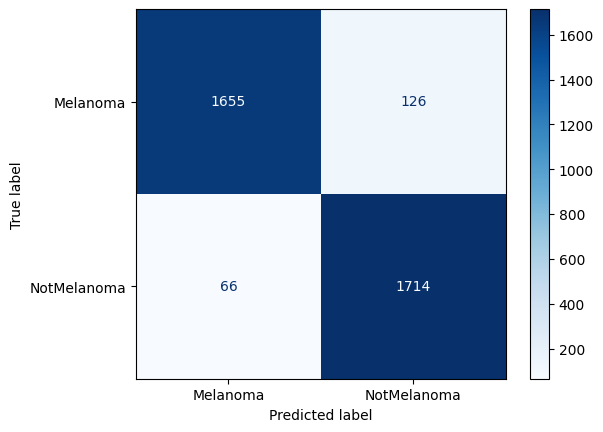

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9617    0.9293    0.9452      1781
 NotMelanoma     0.9315    0.9629    0.9470      1780

    accuracy                         0.9461      3561
   macro avg     0.9466    0.9461    0.9461      3561
weighted avg     0.9466    0.9461    0.9461      3561



In [46]:
evaluate_model(model_dhr_std, test_generator, classes)

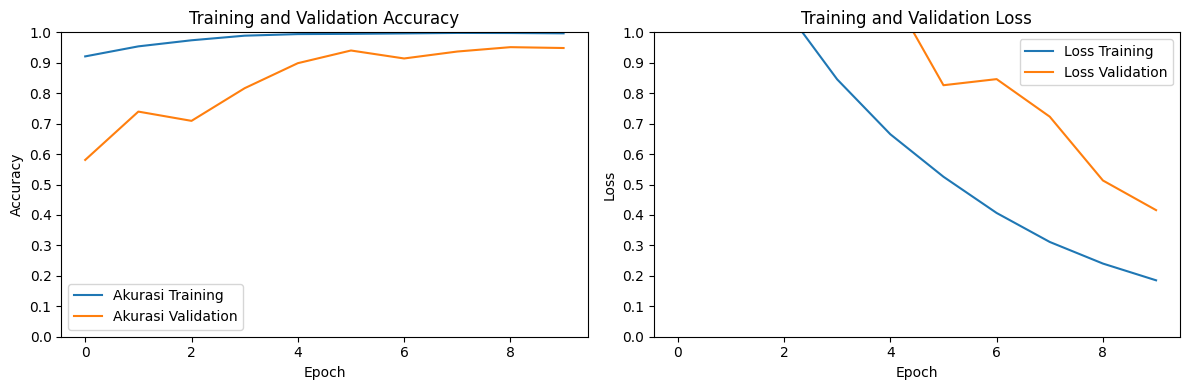

In [47]:
plot_training_history(history)

In [48]:
save_training_history(history, 'model_dhr_std_train_val_results.csv')

## Augmentation

In [49]:
# Metrics
metrics = [
    BinaryAccuracy(name = 'accuracy'),
    Precision(name = 'precision'),
    Recall(name = 'recall'),
    CustomF1Score(name = 'f1_score')
]

In [50]:
# Callbacks
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.5, min_lr = 1e-7)
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

# Optimizer
optimizer = Adam(learning_rate = 1e-4)

In [51]:
# MobileNetV3 Large Model
base_model = MobileNetV3Large(
    #input_shape = (IMG_SIZE, IMG_SIZE, 3),
    include_top = False,
    weights = 'imagenet',
    include_preprocessing = True
)

base_model.trainable = True

model_dhr_aug = Sequential([
    Input(shape = (IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.5),
    Dense(512, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])

In [52]:
model_dhr_aug.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
model_dhr_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, None, None, 960)   2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [53]:
mcp = ModelCheckpoint('model_dhr_aug.h5', save_best_only = True)

In [54]:
start_time = time.time()

history = model_dhr_aug.fit(
    train_generator_dhr_aug,
    epochs = 10,
    validation_data = validation_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    verbose = 1,
    callbacks = [lrd, mcp, es]
)

end_time = time.time()
total_training_time = end_time - start_time
average_time_per_epoch = total_training_time / 10  # Jika epochs = 30

print(f"Total Training Time: {total_training_time:.2f} detik")
print(f"Average Time: {average_time_per_epoch:.2f} detik")

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 1.7544 - accuracy: 0.9176 - precision: 0.8924 - recall: 0.9497 - f1_score: 0.9202

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


333/333 [==============================] - 141s 395ms/step - loss: 1.7544 - accuracy: 0.9176 - precision: 0.8924 - recall: 0.9497 - f1_score: 0.9202 - val_loss: 1.8999 - val_accuracy: 0.7472 - val_precision: 0.6639 - val_recall: 1.0000 - val_f1_score: 0.7980 - lr: 1.0000e-04
Epoch 2/10
333/333 [==============================] - 101s 303ms/step - loss: 1.1458 - accuracy: 0.9515 - precision: 0.9287 - recall: 0.9782 - f1_score: 0.9528 - val_loss: 1.1857 - val_accuracy: 0.9071 - val_precision: 0.8441 - val_recall: 0.9983 - val_f1_score: 0.9147 - lr: 1.0000e-04
Epoch 4/10
333/333 [==============================] - 93s 279ms/step - loss: 0.9239 - accuracy: 0.9592 - precision: 0.9417 - recall: 0.9792 - f1_score: 0.9601 - val_loss: 0.9271 - val_accuracy: 0.9465 - val_precision: 0.9047 - val_recall: 0.9983 - val_f1_score: 0.9492 - lr: 1.0000e-04
Epoch 5/10
333/333 [==============================] - 89s 268ms/step - loss: 0.7416 - accuracy: 0.9618 - precision: 0.9490 - recall: 0.9760 - f1_score:

In [55]:
test_result_dhr_aug = model_dhr_aug.evaluate(test_generator, verbose = 1, batch_size = BATCH_SIZE, return_dict = True)
test_result_dhr_aug

112/112 [==============================] - 29s 264ms/step - loss: 0.3917 - accuracy: 0.9242 - precision: 0.9223 - recall: 0.9264 - f1_score: 0.9243


{'loss': 0.39168477058410645,
 'accuracy': 0.9241786003112793,
 'precision': 0.922259509563446,
 'recall': 0.9264044761657715,
 'f1_score': 0.9243272542953491}

112/112 [==============================] - 15s 135ms/step
Confusion Matrix:
[[1642  139]
 [ 131 1649]]


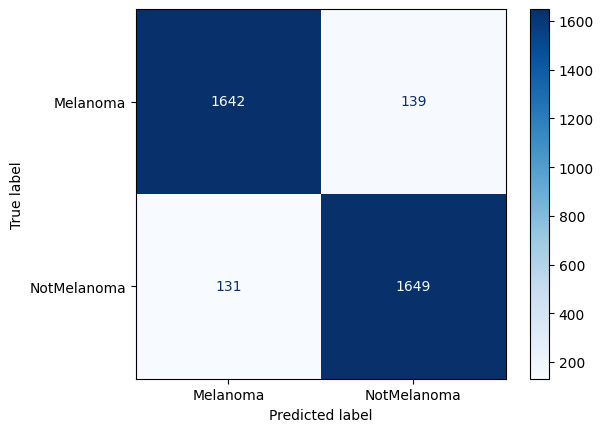

Classification Report:
              precision    recall  f1-score   support

    Melanoma     0.9261    0.9220    0.9240      1781
 NotMelanoma     0.9223    0.9264    0.9243      1780

    accuracy                         0.9242      3561
   macro avg     0.9242    0.9242    0.9242      3561
weighted avg     0.9242    0.9242    0.9242      3561



In [56]:
evaluate_model(model_dhr_aug, test_generator, classes)

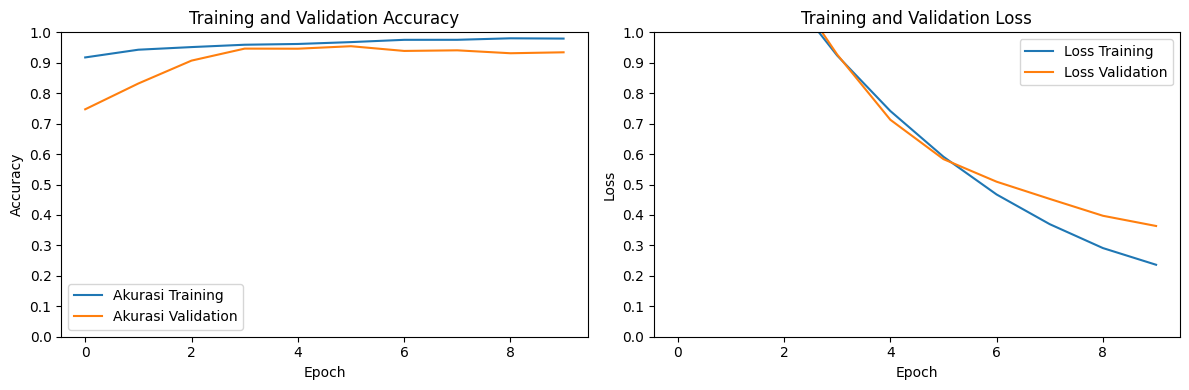

In [57]:
plot_training_history(history)

In [58]:
save_training_history(history, 'model_dhr_aug_train_val_results.csv')

# Results Table

In [59]:
import pandas as pd

def save_test_results_to_csv(results_dict, filename):
    """
    Saves the results of model testing to a CSV file.

    Args:
        results_dict (dict): A dictionary where keys are model names and values
                           are dictionaries of evaluation metrics.
        filename (str, optional): The name of the CSV file. Defaults to "test_results.csv".
    """

    df = pd.DataFrame.from_dict(results_dict, orient='index')
    df.to_csv(filename)

# Example usage (assuming you have your test results in a dictionary)

test_results = {
    "model_default_std": test_result_no_dhr_std,
    "model_default_aug": test_result_no_dhr_aug,
    "model_dhr_std": test_result_dhr_std,
    "model_dhr_aug": test_result_dhr_aug
}

save_test_results_to_csv(test_results, "model_test_results.csv")
pd.read_csv('model_test_results.csv')

,Unnamed: 0,loss,accuracy,precision,recall,f1_score
0,model_default_std,0.492609,0.954226,0.931200,0.980899,0.955404
1,model_default_aug,0.308884,0.948891,0.964535,0.932022,0.948000
2,model_dhr_std,0.421415,0.946083,0.931522,0.962921,0.946961
3,model_dhr_aug,0.391685,0.924179,0.922260,0.926404,0.924327
